<a href="https://colab.research.google.com/github/KRISHANBANSALiitk/Price-Optimization-A-descriptive-predictive-prescriptive-study/blob/main/price_optimization/price_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How Much Is Too Much? Avocado Pricing and Supply Using Mathematical Optimization

A [Food Network article](https://www.foodnetwork.com/fn-dish/news/2018/3/avocado-unseats-banana-as-america-s-top-fruit-import-by-value) from March 2017 declared, "Avocado unseats banana as America's top fruit import." This declaration is incomplete and debatable for reasons other than whether  avocado is a fruit. Avocados are expensive.

As a supplier, setting an appropriate avocado price requires a delicate trade-off.
Set it too high and you lose customers. Set it too low and you won't make a profit.
Equipped with good data, the avocado pricing and supply problem is *ripe* with opportunities for demonstrating the power of optimization and data science.

They say when life gives you avocados, make guacamole.
Just like the perfect guacamole needs the right blend of onion, lemon and spices, finding an optimal avocado price needs the right blend of descriptive, predictive and prescriptive analytics.

|<img src="https://github.com/Gurobi/modeling-examples/blob/master/price_optimization/avocado_image_grocery.jpeg?raw=1" width="500" align="center">|
|:--:|
| <b>Avocados: a quintessential corner of a grocery store. Image Credits: [New York Post](https://nypost.com/2022/02/15/us-will-halt-mexico-avocado-imports-as-long-as-necessary/) </b>|


**Goal**: Develop a data science pipeline for pricing and distribution of avocados to maximize revenue.

This notebook walks through a decision-making pipeline that culminates in a mathematical optimization model.
There are three stages:
- First, understand the dataset and infer the relationships between categories such as the sales, price, region, and seasonal trends.
- Second, build a prediction model that predicts the demand for avocados as a function of price, region, year and the seasonality.
- Third, design an optimization problem that sets the optimal price and supply quantity to maximize the net revenue while incorporating costs for wastage and transportation.


## Load the Packages and the Datasets

We use real sales data provided by the [Hass Avocado Board](https://hassavocadoboard.com/) (HAB), whose aim is to "make avocados America’s most popular fruit". This dataset contains consolidated information on several years' worth of market prices and sales of avocados.

We will now load the following packages for analyzing and visualizing the data.

In [1]:
%pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 46.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import sklearn
import numpy as np

The dataset from HAB contains sales data for the years 2019-2022. This data is augmented by a previous download from HAB available on [Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020) with sales for the years 2015-2018.

Each row in the dataset is the weekly number of avocados sold and the weekly average price of an avocado categorized by region and type of avocado. There are two types of avocados: conventional and organic. In this notebook, we will only consider the conventional avocados.
There are eight large regions, namely the Great Lakes, Midsouth, North East, Northern New England, South Central, South East, West and Plains.

Now, load the data and store into a Pandas dataframe.

In [3]:
avocado = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/HABdata_2019_2022.csv') # dataset downloaded directly from HAB
# avocado = pd.read_csv('HABdata_2019_2022.csv') # dataset downloaded directly from HAB
avocado_old = pd.read_csv('https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/kaggledata_till2018.csv') # dataset downloaded from Kaggle
# avocado_old = pd.read_csv('kaggledata_till2018.csv') # dataset downloaded from Kaggle
avocado = pd.concat([avocado, avocado_old], ignore_index=True)
avocado

,region,date,type,price,units_sold
0,Great_Lakes,1/7/19 0:00,Conventional,1.106743,3812441.96
1,Great_Lakes,1/7/19 0:00,Organic,1.371280,275987.52
2,Great_Lakes,1/13/19 0:00,Conventional,1.063457,3843318.68
3,Great_Lakes,1/13/19 0:00,Organic,1.493384,244991.95
4,Great_Lakes,1/20/19 0:00,Conventional,1.049931,4587957.69
...,...,...,...,...,...
6799,West,11/18/18,Organic,1.610000,334096.14
6800,West,11/25/18,Conventional,1.240000,3260102.17
6801,West,11/25/18,Organic,1.730000,268362.34
6802,West,12/2/18,Conventional,1.200000,4594863.86


## Prepare the Dataset

We will now prepare the data for making sales predictions. Add new columns to the dataframe for the year and seasonality. Let each year from 2015 through 2022 be given an index from 0 through 7 in the increasing order of the year. We will define the peak season to be the months of February through July. These months are set based on visual inspection of the trends, but you can try setting other months.

In [4]:
# Add the index for each year from 2015 through 2022
avocado['date'] = pd.to_datetime(avocado['date'])
avocado['year'] = pd.DatetimeIndex(avocado['date']).year
avocado['year_index'] = avocado['year'] - 2015
avocado = avocado.sort_values(by='date')

# Define the peak season
avocado['month'] = pd.DatetimeIndex(avocado['date']).month
peak_months = range(2,8)        # <--------- Set the months for the "peak season"
def peak_season(row):
    return 1 if int(row['month']) in peak_months else 0

avocado['peak'] = avocado.apply(lambda row: peak_season(row), axis=1)

# Scale the number of avocados to millions
avocado['units_sold'] = avocado['units_sold']/1000000

# Select only conventional avocados
avocado = avocado[avocado['type'] == 'Conventional']

avocado = avocado[['date','units_sold','price','region','year','month','year_index','peak']].reset_index(drop = True)

avocado

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0,0
...,...,...,...,...,...,...,...,...
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,7,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,7,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,7,1
3400,2022-05-15,3.542902,1.514583,Midsouth,2022,5,7,1


## Part 1: Observe Trends in the Data

Now, we will infer sales trends in time and seasonality. For simplicity, let's proceed with data from the United States as a whole.

In [5]:
df_Total_US = avocado[avocado['region']=='Total_US']

### Sales Over the Years

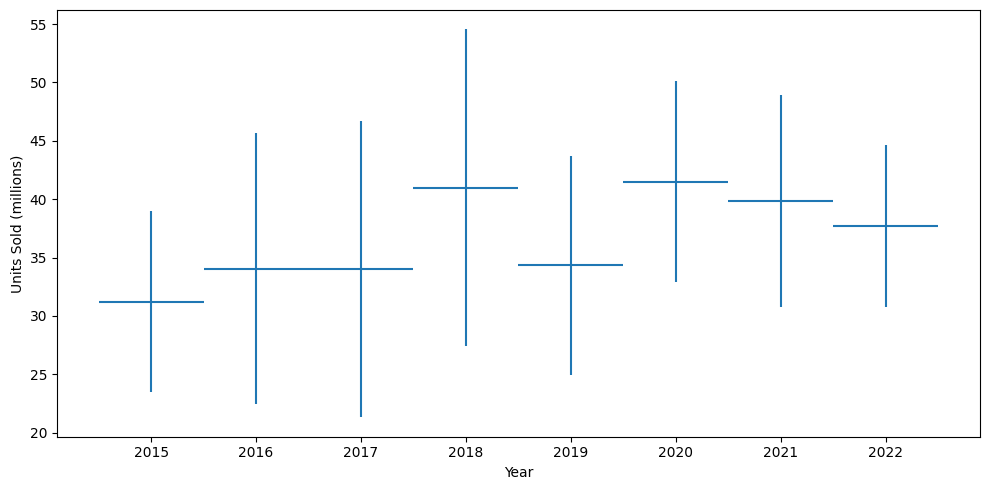

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

mean = df_Total_US.groupby('year')['units_sold'].mean()
std  = df_Total_US.groupby('year')['units_sold'].std()
axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
axes.set_ylabel('Units Sold (millions)')
axes.set_xlabel('Year')

fig.tight_layout()

We can see that the sales generally increased over the years, albeit marginally. The dip in 2019 is the effect of the well-documented [2019 avocado shortage](https://abc7news.com/avocado-shortage-season-prices/5389855/) that led to avocados [nearly doubling in price.](https://abc7news.com/avocado-shortage-season-prices/5389855/)

### Seasonality

We will now see the sales trends within a year.

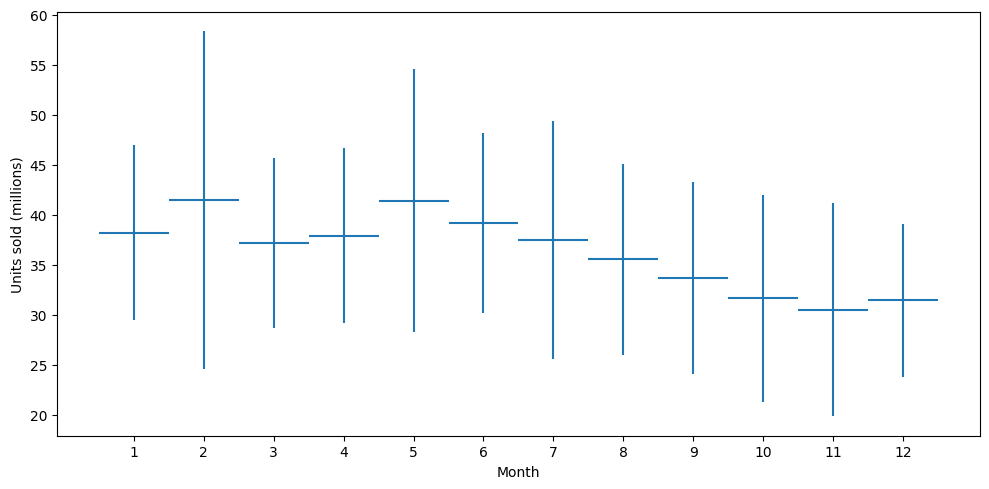

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

mean = df_Total_US.groupby('month')['units_sold'].mean()
std  = df_Total_US.groupby('month')['units_sold'].std()

axes.errorbar(mean.index, mean, xerr=0.5, yerr=2*std, linestyle='')
axes.set_ylabel('Units Sold (millions)')
axes.set_xlabel('Month')

fig.tight_layout()

plt.xlabel('Month')
axes.set_xticks(range(1,13))
plt.ylabel('Units sold (millions)')
plt.show()

We see a Super Bowl peak in February and a Cinco de Mayo peak in May.

### Correlations

Now, we will see how the variables are correlated with each other.
The end goal is to predict sales given the price of an avocado, year and seasonality (peak or not).

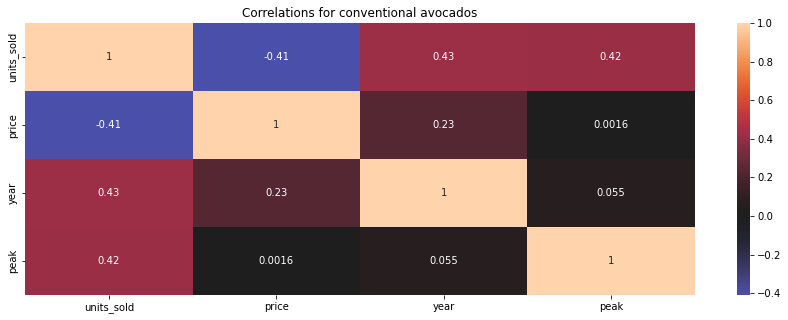

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.heatmap(df_Total_US[['units_sold', 'price', 'year', 'peak']].corr(),annot=True, center=0,ax=axes)

axes.set_title('Correlations for conventional avocados')
plt.show()

As expected, the sales quantity has a negative correlation with the price per avocado. The sales quantity has a positive correlation with the year and season being a peak season.

### Regions

Finally, we will see how the sales differ among the different regions. This will determine the number of avocados that we want to supply to each region.

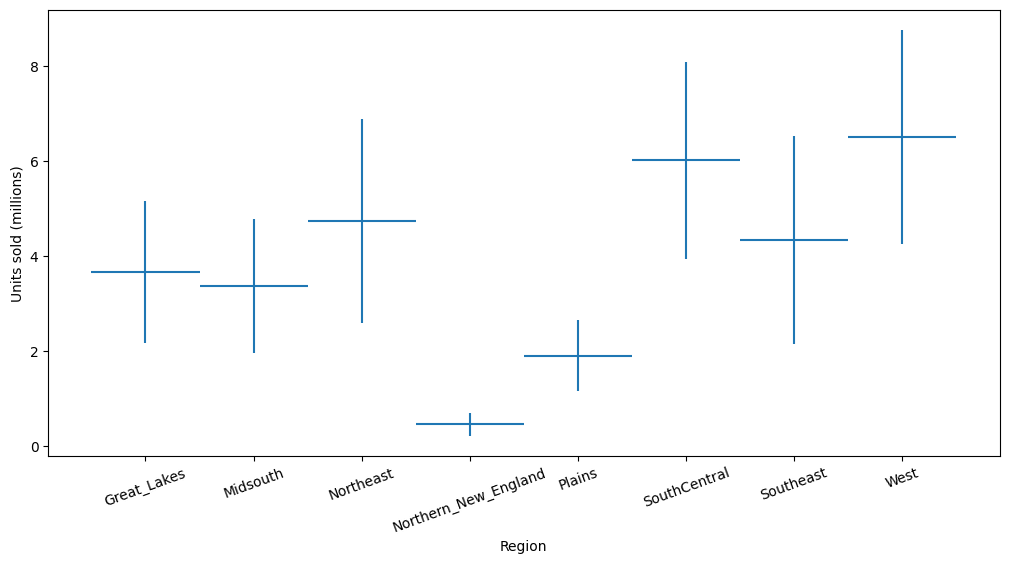

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

regions = ['Great_Lakes','Midsouth','Northeast','Northern_New_England','SouthCentral','Southeast','West','Plains']
df = avocado[avocado.region.isin(regions)]

mean = df.groupby('region')['units_sold'].mean()
std  = df.groupby('region')['units_sold'].std()

axes.errorbar(range(len(mean)), mean, xerr=0.5, yerr=2*std, linestyle='')

fig.tight_layout()

plt.xlabel('Region')
plt.xticks(range(len(mean)), pd.DataFrame(mean)['units_sold'].index,rotation=20)
plt.ylabel('Units sold (millions)')
plt.show()

Clearly, west-coasters love avocados.

## Part II: Predict the Sales

The trends observed in Part I motivate us to construct a prediction model for sales using the independent variables- price, year, region and seasonality.
Henceforth, the sales quantity will be referred to as the *predicted demand*.

Let us now construct a linear regressor for the demand.
Note that the region is a categorical variable.
The linear regressor can be mathematically expressed as:

$$demand = \beta_0 + \beta_1 * price + \sum\limits_{region} \beta^{region}_3 * \mathbb{1}(region)  +  \beta_4 w_{year}*year +  \beta_5  * \mathbb{1}(peak).$$

Here, the $\beta$ values are weights (or "co-efficients") that have to be learned from the data.
Note that the notation $\mathbb{1}(region)$ is an indicator function that takes the value $1$ for each region in the summation. The value of $\mathbb{1}(peak)$ is $1$ if we consider the peak season.

To validate the regression model, we will randomly split the dataset into $80\%$ training and $20\%$ testing data and learn the weights using sklearns.

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split the data for training and testing
train, test = train_test_split(df, train_size=0.8, random_state=1)
df_train = pd.DataFrame(train, columns=df.columns)
df_test = pd.DataFrame(test, columns=df.columns)

# Train the model
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod = smf.ols(formula,data=df_train)
result = mod.fit()
result.summary()

# Get R^2 from test data
y_true = df_test['units_sold']
y_pred = result.predict(df_test)
print("The R^2 value in the test set is",r2_score(y_true, y_pred))

The R^2 value in the test set is 0.8982069358257861


We can observe a good $R^2$ value in the test set. We will now train the fit the weights to the full dataset.

In [10]:
formula = 'units_sold ~ price + year_index + C(region)+ peak'
mod_full = smf.ols(formula,data=df)
result_full = mod_full.fit()

y_true_full = df['units_sold']
y_pred_full = result_full.predict(df)
print("The R^2 value in the full dataset is",r2_score(y_true_full, y_pred_full))

# Get the weights and store it
coef_dict = result_full.params.to_dict()
coef_dict['C(region)[T.Great_Lakes]'] = 0

The R^2 value in the full dataset is 0.9066729322212482


## Part III: Optimize for Price and Supply of Avocados

Knowing how the price of an avocado affects the demand, how can we set the optimal avocado price?
We don't want to set the price too high, since that could drive demand and sales down. At the same time, setting the price too low could be sub-optimal when maximizing revenue. So what is the sweet spot?

On the distribution logistics, we want to make sure that there are enough avocados across the regions. We can address these considerations in a mathematical optimization model.
An optimization model finds the **best solution** according to an **objective function** such that the solution satisfies a set of **constraints**.
Here, a solution is expressed as a vector of real values or integer values called **decision variables**.
Constraints are a set of equations or inequalities written as a function of the decision variables.

At the start of each week, assume that the total number of available products is finite. This quantity needs to be distributed to the various regions while maximizing net revenue. So there are two key decisions - the price of an avocado in each region, and the number of avocados allocated to each region.

Let us now define some input parameters and notations used for creating the model. The subscript $r$ will be used to denote each region.

### Input Parameters
- $R$: set of regions,
- $d(p,r)$: predicted demand in region $r\in R$ when the avocado per product is $p$,
- $B$: available avocados to be distributed across the regions,
- $c_{waste}$: cost ($\$$) per wasted avocado,
- $c^r_{transport}$: cost ($\$$) of transporting a avocado to region $r \in R$,
- $a^r_{min},a^r_{max}$: minimum and maximum price ($\$$) per avocado for reigon $r \in R$,
- $b^r_{min},b^r_{max}$: minimum and maximum number of avocados allocated to region $r \in R$,

The following code loads the Gurobi python package and initiates the optimization model.
The value of $B$ is set to $30$ million avocados, which is close to the average weekly supply value from the data.
For illustration, let us consider the peak season of 2021.
The cost of wasting an avocado is set to $\$0.10$.
The cost of transporting an avocado ranges between $\$0.10$ to $\$0.50$ based on each region's distance from the southern border, where the [majority of avocado supply comes from](https://www.britannica.com/plant/avocado).
Further, we can set the price of an avocado to not exceed $\$ 2$ apiece.

In [11]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model("Avocado_Price_Allocation")

# Sets and parameters
R = regions   # set of all regions

B = 30  # total amount ot avocado supply

peak_or_not = 1 # 1 if it is the peak season; 1 if isn't
year = 2022

c_waste = 0.1 # the cost ($) of wasting an avocado
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}
# the cost of transporting an avocado

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
a_min = {r: 0 for r in R} # minimum avocado price in each region
a_max = {r: 2 for r in R} # maximum avocado price in each region
b_min = dict(df.groupby('region')['units_sold'].min())  # minimum number of avocados allocated to each region
b_max = dict(df.groupby('region')['units_sold'].max())   # maximum number of avocados allocated to each region

Restricted license - for non-production use only - expires 2026-11-23


### Decision Variables

Let us now define the decision variables.
In our model, we want to store the price and number of avocados allocated to each region. We also want variables that track how many avocados are predicted to be sold and how many are predicted to be wasted.
The following notation is used to model these decision variables, indexed for each region $r$.

$p_r$: the price of an avocado ($\$$) in region $r$,

$x_r$: the number of products avocados supplied to region $r$,

$s_r = \min \{x_r,d_r(p_r)\}$: the predicted number of avocados sold in region $r$,

$w_r = x_r - s_r$: the predicted number of avocados wasted in region $r$

We will now add the variables to the Gurobi model.

In [12]:
p = m.addVars(R,name="p",lb=a_min, ub=a_max)   # price of avocados in each region
x = m.addVars(R,name="x",lb=b_min,ub=b_max)  # quantity supplied to each region
s = m.addVars(R,name="s",lb=0)   # predicted amount of sales in each region for the given price
w = m.addVars(R,name="w",lb=0)   # excess wasteage in each region

Now, let's create an expression for the predicted demand in each region as a function of price. Note that apart from the price, none of the other parameters in this prediction function (such as region, year and seasonality) are decision variables, and hence can be treated as constants.

In [13]:
d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}
for r in R:
    print(d[r])

7.113205674224991 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
6.870512520547112 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
8.546225510868233 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
4.093961883587112 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
8.827017748198452 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
7.69719584088616 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
9.715005122866257 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>
5.298172801834584 + -2.20377010489025 <gurobi.Var *Awaiting Model Update*>


### Set the Objective

Next, we will define the objective function: we want to maximizing the **net revenue**. The revenue from sales in each region is calculated by the price of an avocado in that region multiplied by the quantity sold there. There are two types of costs incurred: the wastage costs for excess unsold avocados and the cost of transporting the avocados to the different regions.

The net revenue is the sales revenue subtracted by the total costs incurred. We assume that the purchase costs are fixed and are not incorporated in this model.

Using the defined decision variables, the objective can be written as follows.

\begin{align}
\textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r - c^r_{transport} * x_r)&
\end{align}

Let us now add the objective function to the model.

In [14]:
m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R))
m.ModelSense = GRB.MAXIMIZE

### Add the Supply Constraint

We now introduce the constraints. The first constraint is to make sure that the total number of avocados supplied is equal to $B$, which can be mathematically expressed as follows.

\begin{align*}
\sum_{r} x_r &= B
\end{align*}

The following code adds this constraint to the model.

In [15]:
m.addConstr(sum(x[r] for r in R) == B)
m.update()

### Add Constraints That Define Sales Quantity

Next, we should define the predicted sales quantity in each region.
We can assume that if we supply more than the predicted demand, we sell exactly the predicted demand.
Otherwise, we sell exactly the allocated amount.
Hence, the predicted sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$.
This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*}
s_r &\leq x_r  \\
s_r &\leq d(p_r,r)  
\end{align*}

These constraints will ensure that the sales quantity $s_r$ in region $r$ is  greater than neither the allocated quantity nor the predicted demand. Note that the maximization objective function tries to maximize the revenue from sales, and therefore the optimizer will maximize the predicted sales quantity. This is assuming that the surplus and transportation costs are less than the sales price per avocado. Hence, these constraints along with the objective will ensure that the sales are equal to the minimum of supply and predicted demand.

Let us now add these constraints to the model.

In [16]:
m.addConstrs((s[r] <= x[r] for r in R))
m.addConstrs((s[r] <= d[r] for r in R))
m.update()

### Add the Wastage Constraints

Finally, we should define the predicted wastage in each region, given by the supplied quantity that is not predicted to be sold. We can express this mathematically for each region $r$.

\begin{align*}
w_r &= x_r - s_r
\end{align*}

We can add these constraints to the model.

In [17]:
m.addConstrs((w[r] == x[r]-s[r] for r in R))
m.update()

### Fire Up the Solver

We have added the decision variables, objective function, and the constraints to the model.
The model is ready to be solved.
Before we do so, we should let the solver know what type of model this is.
The default setting assumes that the objective and the constraints are linear functions of the variables.

In our model, the objective is **quadratic** since we take the product of price and the predicted sales, both of which are variables.
Maximizing a quadratic term is said to be **non-convex**, and we specify this using a Gurobi parameter value to be $2$.
See [here](https://www.gurobi.com/documentation/9.5/refman/nonconvex.html) for more details.

In [18]:
m.Params.NonConvex = 2
m.optimize()

Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
NonConvex  2

Optimize a model with 25 rows, 32 columns and 64 nonzeros
Model fingerprint: 0x3d9c9c04
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e-01, 5e-01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [2e-01, 1e+01]
  RHS range        [4e+00, 3e+01]

Continuous model is non-convex -- solving as a MIP

Presolve removed 8 rows and 8 columns
Presolve time: 0.00s
Presolved: 34 rows, 34 columns, 81 nonzeros
Presolved model has 8 bilinear constraint(s)
Variable types: 34 continuous, 0 integer (0 binary)
Found heuristic solution: objective 42.5082914

Root relaxation: objective 5.288486e+01, 36 iterations, 0.00 seconds (0

The solver solved the optimization problem in less than a second.
Let us now analyze the optimal solution by storing it in a Pandas dataframe.

In [19]:
solution = pd.DataFrame()
solution['Region'] = R
solution['Price'] = [p[r].X for r in R]
solution['Allocated'] = [round(x[r].X,8) for r in R]
solution['Sold'] = [round(s[r].X,8) for r in R]
solution['Wasted'] = [round(w[r].X,8) for r in R]
solution['Pred_demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million"%opt_revenue)
solution


 The optimal net revenue: $42.508291 million


,Region,Price,Allocated,Sold,Wasted,Pred_demand
0,Great_Lakes,1.663872,3.446414,3.446414,1.000000e-08,3.446414
1,Midsouth,1.508809,5.272290,3.545445,1.726845e+00,3.545445
2,Northeast,2.000000,4.138685,4.138685,1.000000e-08,4.138685
3,Northern_New_England,1.441157,0.917984,0.917984,0.000000e+00,0.917984
4,SouthCentral,2.000000,4.419478,4.419478,1.000000e-08,4.419478
5,Southeast,1.746370,3.848598,3.848598,2.000000e-08,3.848598
6,West,2.000000,5.307465,5.307465,2.000000e-08,5.307465
7,Plains,1.202070,2.649086,2.649086,2.000000e-08,2.649086


Let us now visualize a scatter plot between the price and the number of avocados sold (in millions) for the eight regions.

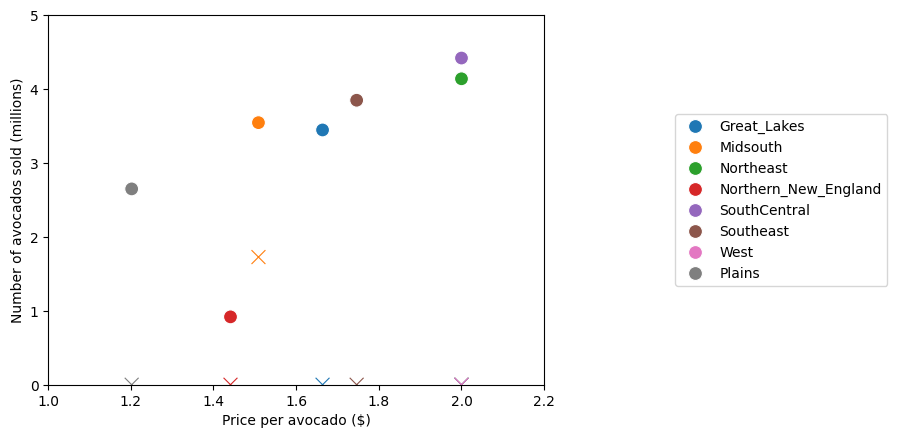

The circles represent sales quantity and the cross markers represent the wasted quantity.


In [20]:
fig, ax = plt.subplots(1,1)
plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0, 5)
plt.xlim(1, 2.2)
ax.set_xlabel('Price per avocado ($)')
ax.set_ylabel('Number of avocados sold (millions)')
plt.show()
print("The circles represent sales quantity and the cross markers represent the wasted quantity.")

## Experiment with Parameter Settings

While this notebook walked through how to build an optimization model piece-by-piece, the following code contains the overall optimization model. You can input different parameter values and see how the optimal solution changes.
The value of $B$ can be controlled using the slider below the cell.


In [21]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import plotly.express as px

peak_or_not = 1 #
year = 2021

# Sets and parameters
R = regions
c_waste = 0.1
c_transport = {'Great_Lakes': .3,'Midsouth':.1,'Northeast':.4,'Northern_New_England':.5,'SouthCentral':.3,'Southeast':.2,'West':.2,'Plains':.2}

# Get the lower and upper bounds for price (p) and amount to be stocked (x) from the dataset
price_min = dict(df.groupby('region')['price'].min())
price_max = dict(df.groupby('region')['price'].max())
sold_min = dict(df.groupby('region')['units_sold'].min())
sold_max = dict(df.groupby('region')['units_sold'].max())



def solve_MIQP(x):
    B = x

    # Initialize Model
    m = gp.Model("Avocado_Price_Allocation")

    # Variables. Adjust the bounds here
    x = m.addVars(R,name="x",lb=sold_min,ub=sold_max)
    p = m.addVars(R,name="p",lb=0, ub=2)
    s = m.addVars(R,name="s",lb=0)
    w = m.addVars(R,name="w",lb=0)
    i = m.addVars(R,name="i",vtype=GRB.BINARY)

    # Predictor expression for demand
    d = {r: (coef_dict['Intercept']+coef_dict['price']*p[r] + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R}


    # Set the objective
    m.ModelSense = GRB.MAXIMIZE
    m.setObjective(sum(p[r]*s[r] - c_waste*w[r] - c_transport[r]*x[r] for r in R))

    # Add the constraints
    m.addConstrs((s[r] <= x[r] for r in R))
    m.addConstrs((s[r] <= d[r] for r in R))
    m.addConstrs((x[r] == w[r]+s[r] for r in R))
    m.addConstr(sum(x[r] for r in R) == B)

    # Solve
    m.setParam('OutputFlag', 0)
    m.Params.NonConvex = 2
    m.update()
    m.optimize()
    if m.status == 4:
        print('The problem is infeasible. Try changing the parameter values.')
    else:
        global solution, opt_revenue
        solution = pd.DataFrame()
        solution['Region'] = R
        solution['Price'] = [p[r].X for r in R]
        solution['Allocated'] = [round(x[r].X,8) for r in R]
        solution['Sold'] = [round(s[r].X,8) for r in R]
        solution['Wasted'] = [round(w[r].X,8) for r in R]
        solution['Demand'] = [(coef_dict['Intercept']+coef_dict['price']*p[r].X + coef_dict['C(region)[T.%s]'%r] + coef_dict['year_index']*(year-2015) + coef_dict['peak']*peak_or_not) for r in R]

        opt_revenue = m.ObjVal
        if display_figures:
            print("\n Net revenue: $%f million"%opt_revenue)
            print("\nThe optimal solution is as follows. Price per avocado in dollars. Allocated avocados, wasted avocados, and predicted demand in millions.\n")
            print(solution)

            print("\n Scatter plot of price vs number of avocados sold (millions) for the eight regions:")
            fig, ax = plt.subplots(1,1)
            plot_sol = sns.scatterplot(data=solution,x='Price',y='Sold',hue='Region',s=100)
            plot_waste = sns.scatterplot(data=solution,x='Price',y='Wasted',marker='x',hue='Region',s=100,legend = False)

            plot_sol.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plot_waste.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
            plt.ylim(0, 5)
            plt.xlim(1, 2.2)
            ax.set_xlabel('Price per avocado ($)')
            ax.set_ylabel('Number of avocados sold (millions)')
            plt.show()
            print("The circles represent sales quantity and the cross markers represent the wasted quantity.")


        return m.ObjVal, solution


display_figures = 1
print("Select a value for the available inventory (B) (in millions):\n")
interact(solve_MIQP, x=(15,40,1))



Select a value for the available inventory (B) (in millions):



interactive(children=(IntSlider(value=27, description='x', max=40, min=15), Output()), _dom_classes=('widget-i…

<function __main__.solve_MIQP(x)>

**Observations**:
- When the supply is highly constrained, i.e., for a very small B, the model sets high prices => demand is low => allocation satisfies the demand exactly
- With increasing supply => the prices go down => demand goes up => the allocation can continue to satisfy demand
- With a very high supply, the wasteage starts going up


## Compare Optimal Versus Actual Net Revenue

Finally, we can run the optimization model for each week in a year and compare the optimal predicted revenue with the actual weekly revenue.
Let us assume that there were no wastage costs in the actual weekly number since this information is unknown.

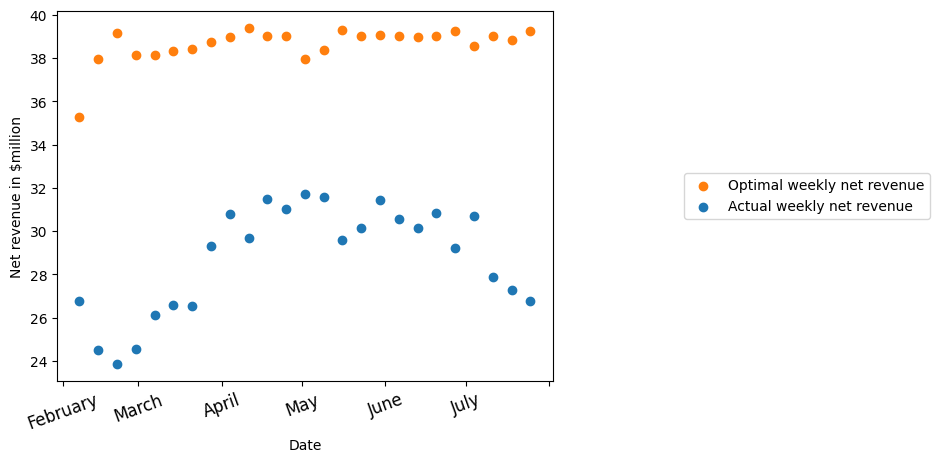

For the average peak season week in 2021, the optimal solution yields 35.288636 % more net revenue than the actual supply chain.


In [22]:
# Create a subset of data for the given year and season
df_subset = df[(df['year']==year) & (df['peak']==peak_or_not)]
df_subset['price_minus_transport'] = df_subset['price'] - df_subset['region'].map(c_transport)
dates = sorted(list(set(df_subset.date)))

# Run the optimizer for each week
actual, optimal, display_figures = [], [], 0
for date in dates:
    df_date = df_subset[df_subset['date']==date]
    weekly_sold = (df_date['units_sold']).values.sum()
    optimal.append(solve_MIQP(weekly_sold)[0])

    actual_weekly_revenue = (df_date['units_sold']*(df_date['price_minus_transport'])).values.sum()
    actual.append(actual_weekly_revenue)

# Plot the two scatter plots
fig_comparison, ax_comparison = plt.subplots(1,1)
actual_plot = plt.scatter(dates, actual)
optimal_plot = plt.scatter(dates, optimal)
plt.legend((optimal_plot,actual_plot),('Optimal weekly net revenue','Actual weekly net revenue'),loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
x_ticks_labels = list(dict.fromkeys([date.strftime("%B") for date in  dates]))
ax_comparison.set_xticklabels(x_ticks_labels, rotation=20, fontsize=12)
ax_comparison.set_xlabel('Date')
ax_comparison.set_ylabel('Net revenue in $million')

plt.show()

difference = [(i - j)/j for i, j in zip(optimal, actual)]
print("For the average peak season week in %i, the optimal solution yields %f %% more net revenue than the actual supply chain."%(year,100*sum(difference)/len(difference)))


Now, we can compare the price and sales between the optimal solution and actual data for each week. Select a week using the interactive tool and see the difference.

In [23]:
def compare_with_actual(x):
    df_date = df_subset[df_subset['date']==x]
    weekly_sold = (df_date['units_sold']).values.sum()
    print(weekly_sold)
    opt_revenue, opt_solution = solve_MIQP(weekly_sold)

    df_comparison = df_date.merge(opt_solution, left_on='region', right_on='Region')

    df_comparison = df_comparison[['Region','price','Price','units_sold','Sold']]
    df_comparison = df_comparison.rename({'price': 'Actual price', 'Price': 'Optimal price','units_sold': 'Actual sold', 'Sold': 'Optimal sold'}, axis=1)
    print(df_comparison.sort_values(by='Region').reset_index(drop=True))

display_figures = 0
print("Select a value for the available inventory (B) (in millions):\n")
interact(compare_with_actual, x=dates)


Select a value for the available inventory (B) (in millions):



interactive(children=(Dropdown(description='x', options=(Timestamp('2021-02-07 00:00:00'), Timestamp('2021-02-…

<function __main__.compare_with_actual(x)>

Notice that for certain weeks and certain regions, the optimizer sets a higher price than the actual price if it foresees that even the dip in demand is worth it. In certain other cases, a lower price is preferred. Overall, the optimal solution rakes in close to 35% more net revenue than the actual case.
This analysis demonstrates that the optimal pricing and supply of avocados could improve the efficiency of the avocado supply chain.

With the right optimization tools, every day could be game day.

In [24]:
gp.disposeDefaultEnv()

Freeing default Gurobi environment
